The following code is based on the work done by Tess Ferrandez.

https://github.com/TessFerrandez/research-papers/blob/prod/facenet/FaceNet.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# cd /content/drive/MyDrive

In [ ]:
cd /content/drive/MyDrive/researchPaperAssignment/models/zeiler

/content/drive/MyDrive/researchPaperAssignment/models/inception


In [ ]:
!pip install -q pyyaml h5py

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import pickle
import os

""" For ZF Model uncomment it """
from zfnet import create_model

import sys
sys.path.append(os.path.join('..', '..'))

from global_params import *

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
import cv2 as cv

# Using transfer learning to perform prediction on a small dataset

In [ ]:
# building the model
model = create_model()

In [ ]:
train_path = os.path.join('nnfl_crop')

train_batches = keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    # rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
).flow_from_directory(
    train_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=22,
    class_mode='sparse',
    color_mode='grayscale'
)

Found 52 images belonging to 3 classes.


In [ ]:
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.003),
    loss=tfa.losses.TripletSemiHardLoss(margin=0.2),
)

In [ ]:
model.load_weights('best_zfnet_model2.h5')

In [ ]:
history = model.fit(
    train_batches,
    epochs=8,
    steps_per_epoch=2,
)

Epoch 1/8
2/2 [==============================] - 0s 62ms/step - loss: 5.3221e-04
Epoch 2/8
2/2 [==============================] - 0s 27ms/step - loss: 0.0000e+00
Epoch 3/8
2/2 [==============================] - 0s 56ms/step - loss: 0.0075
Epoch 4/8
2/2 [==============================] - 0s 29ms/step - loss: 0.0035
Epoch 5/8
2/2 [==============================] - 0s 55ms/step - loss: 0.0042
Epoch 6/8
2/2 [==============================] - 0s 53ms/step - loss: 0.0011
Epoch 7/8
2/2 [==============================] - 0s 26ms/step - loss: 0.0119
Epoch 8/8
2/2 [==============================] - 0s 62ms/step - loss: 0.0023


# Load data and generate embeddings

In [ ]:
from PIL import Image, ImageOps
class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    identityMetadata = IdentityMetadata
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(identityMetadata(path, i, f))
    return np.array(metadata)

def load_image(path):
    img = Image.open(path)
    img = img.resize((input_shape[0],input_shape[1]))
    img2 = ImageOps.grayscale(img) 
    return np.asarray(img2)

# def load_image(folder_path):
#     img = cv.imread(folder_path, 1)
#     return img

In [ ]:
!ls

best_inception_model2.h5  meta_zf.tsv
best_inception_model3.h5  model.h5
best_inception_model4.h5  nnfl_crop
best_inception_model5.h5  nnfl_image
best_inception_model6.h5  __pycache__
best_inception_model.h5   shape_predictor_68_face_landmarks.dat
best_zfnet_model2.h5	  test
best_zfnet_model.h5	  TestAccuracy2.ipynb
dummy.h5		  TestAccuracy.ipynb
face_aligner_mod.py	  train
history2.csv		  training
history3.csv		  training_2
history4.csv		  training_3
InceptionModel2.ipynb	  Training5
inceptionModel.py	  vecs2.tsv
lfw			  vecs3.tsv
lfw.zip			  vecs4.tsv
meta2.tsv		  vecs_train2.tsv
meta2_zf.tsv		  vecs_train.tsv
meta3.tsv		  vecs_zf2.tsv
meta4.tsv		  vecs_zf.tsv
meta_train2.tsv		  zfnet.py
meta_train.tsv


In [ ]:
metadata = load_metadata('nnfl_crop')

In [ ]:
from progressbar import ProgressBar

num_images = metadata.shape[0]
progress = ProgressBar(num_images)
progress.start()

embedded = np.zeros((num_images, 128))

for i, m in enumerate(metadata):
    #print(m.image_path())
    img = load_image(m.image_path())
    # scale RGB values to interval [0,1]
    img = (img / 255).astype(np.float32)
    img = img.reshape(input_shape)
    # obtain embedding vector for image
    embedded[i] = model.predict(np.expand_dims(img, axis=0))[0]
    # embedded[i] = face_recognition.face_encodings(img)[0]
    progress.update(i)

\ |                             #                    | 51 Elapsed Time: 0:00:02

# Visualize distance between images

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(10,5))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()), cmap='gray', vmin=0, vmax=255)
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()), cmap='gray', vmin=0, vmax=255)

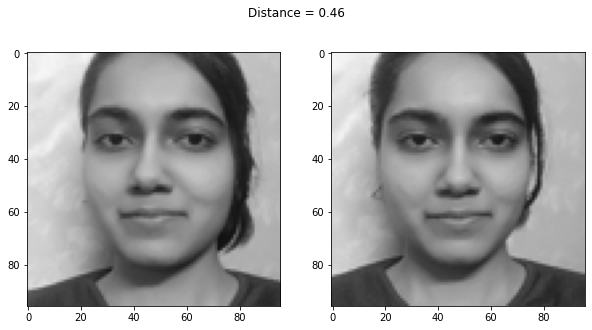

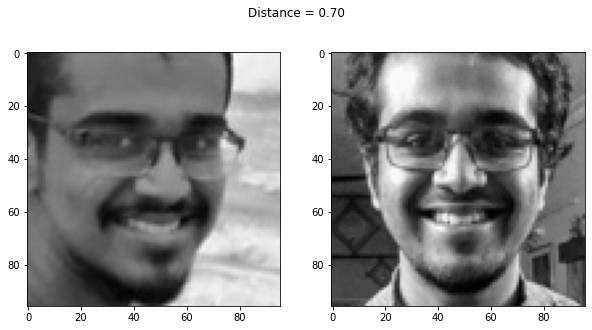

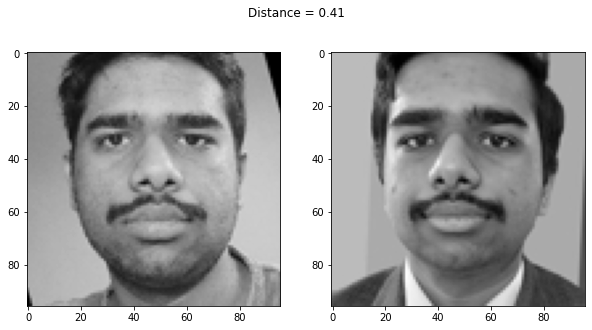

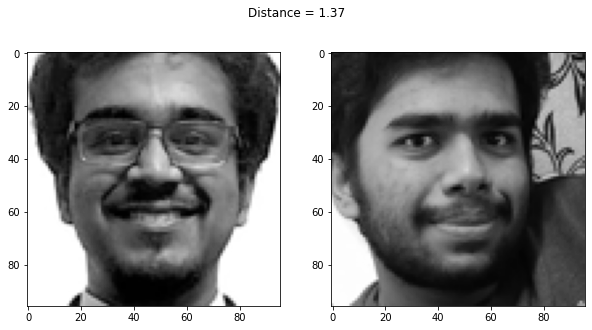

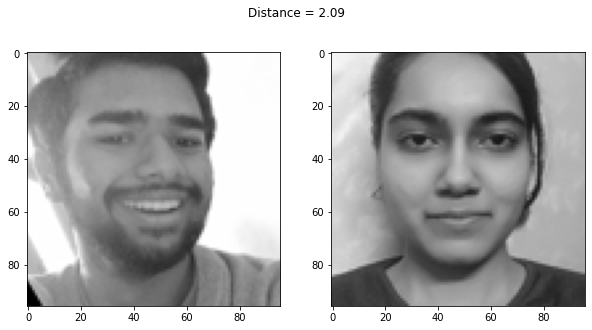

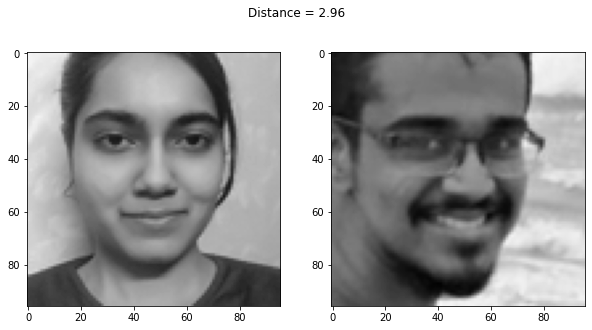

In [ ]:
show_pair(41,50)
show_pair(5,3)
show_pair(18,17)
show_pair(1,24)
show_pair(30,50)
show_pair(48,8)

# Plot histogram to analyse distance between

1.   Anchor and Positive image
2.   Anchor and Negative image

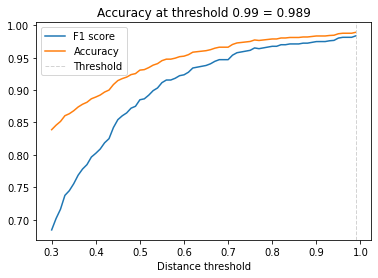

In [ ]:
distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

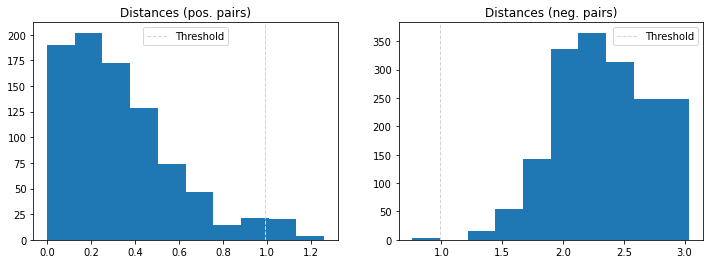

In [ ]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

# Find classification accuracy using SVM and KNN

In [ ]:
targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

test_idx = np.arange(metadata.shape[0]) % 2 == 0
train_idx = np.arange(metadata.shape[0]) % 2 != 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
y_pred_svc = svc.predict(X_test)
acc_svc = accuracy_score(y_test, y_pred_svc)

print(f'KNN accuracy = {acc_knn*100}, SVM accuracy = {acc_svc*100}\n')

KNN accuracy = 100.0, SVM accuracy = 100.0



# Show Predictions

In [ ]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

def show_prediction(example_idx):
    plt.figure()
    example_image = load_image(metadata[test_idx][example_idx].image_path())
    example_prediction = svc.predict([embedded[test_idx][example_idx]])
    example_identity = encoder.inverse_transform(example_prediction)[0]

    plt.imshow(example_image)
    plt.title(f'Recognized as {example_identity}');
    

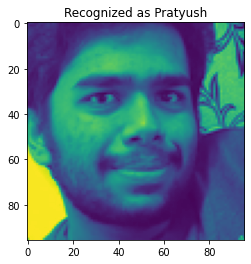

In [ ]:
show_prediction(12)

# Visualize embeddings in 2D plane

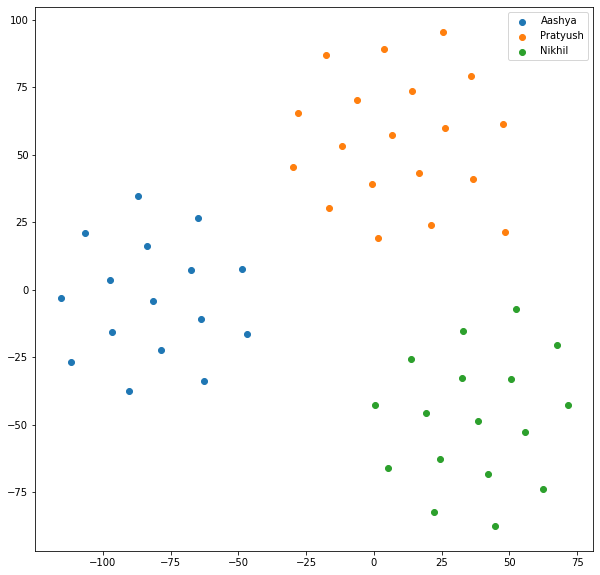

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

plt.figure(figsize=(10,10))

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

In [ ]:
%rm -rf /content/drive/MyDrive/cropped/

# Crop the images for better accuracy

In [ ]:
from imutils import face_utils
from imutils.face_utils import rect_to_bb
from imutils.face_utils import FaceAligner
import cv2 as cv
import os
import numpy as np
import dlib

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/researchPaperAssignment/models/shape_predictor_68_face_landmarks.dat')
fa = FaceAligner(predictor , desiredFaceWidth = 256)
path_from = "NNFL_group_images"
folder_to = "cropped"

def cropped_img(path):
    dirs = os.listdir(path)

    for dir_name in dirs:
        subject_dir_path = path + "/" + dir_name
        subject_images_names = os.listdir(subject_dir_path)
        try:
            os.mkdir(folder_to+"/"+dir_name)
        except OSError as err:
            print(err)
        count = 0
        for image_name in subject_images_names:
            image_path = subject_dir_path + "/" + image_name
            img = cv.imread(image_path, 1)
            print(image_path)
            gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

            #Detect faces in the grayscale form
            faces = detector(gray_img,0)
            for face in faces:
                if face is None:
                    continue
                count+=1
                (x,y,w,h) = face_utils.rect_to_bb(face)
                face_aligned = fa.align(img,gray_img,face)
                # cropped_face = face_aligned[y:y+h, x:x+w]
                cv.imwrite(folder_to+"/{}/{}".format(dir_name,str(count)+'.jpg'), face_aligned)

cropped_img(path_from)

NNFL_group_images/Nikhil/yearbook_1.png
NNFL_group_images/Nikhil/linkedin_profile_pic.png
NNFL_group_images/Nikhil/linkedin_vignette.jpeg
NNFL_group_images/Nikhil/ushas.png
NNFL_group_images/Nikhil/beach.jpeg
NNFL_group_images/Nikhil/beach copy.jpeg
NNFL_group_images/Nikhil/WhatsApp Image 2020-11-15 at 12.16.33 AM copy.jpeg
NNFL_group_images/Nikhil/beach flipped.png
NNFL_group_images/Nikhil/beach_pos10.png
NNFL_group_images/Nikhil/beach_neg10.png
NNFL_group_images/Nikhil/linkedin_profile_pic_flipped.png
NNFL_group_images/Nikhil/linkedin_profile_pic_pos5.png
NNFL_group_images/Nikhil/linkedin_profile_pic_neg5.png
NNFL_group_images/Nikhil/linkedin_vignette_flipped.png
NNFL_group_images/Nikhil/ushas_flipped.png
NNFL_group_images/Nikhil/ushas_vertical.png
NNFL_group_images/Nikhil/yearbook_1_flipped.png
NNFL_group_images/Nikhil/WhatsApp Image 2020-11-15 at 12.16.33 AM_flipped.jpeg
NNFL_group_images/Pratyush/101.jpg
NNFL_group_images/Pratyush/IMG_20201125_165313.jpg
NNFL_group_images/Pratyush

In [ ]:
!pip install face_recognition

     |████████████████████████████████| 100.2MB 123kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=2729fff0bf18519483f4f0c5899624afecf0a5a69380dbb950a08741f9468b23
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


#If using

*   Inception Model
*   ZF Model



In [ ]:
def predict(face_aligned):
    prob = svc._predict_proba_lr(model.predict(face_aligned))
    # prob = knn.predict_proba(model.predict(face_aligned))
    result = np.where(prob[0] == np.amax(prob[0]))
    print(result)
    print(prob)
    # if prob[0][result[0]] <= threshold:
    #     return ('unknown', prob[0][result[0]])

    return (result[0], prob[0][result[0]])

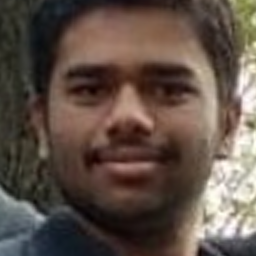

(array([1]),)
[[0.31213403 0.41549369 0.27237228]]
Nikhil [0.41549369]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


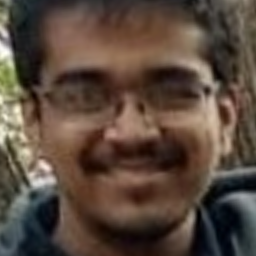

(array([1]),)
[[0.33821237 0.4671346  0.19465302]]
Nikhil [0.4671346]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


True

In [ ]:
from imutils import face_utils
from imutils.face_utils import rect_to_bb
from imutils.face_utils import FaceAligner
import cv2 as cv
import os
import numpy as np
import dlib
from google.colab.patches import cv2_imshow
from matplotlib import cm
import face_recognition

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
fa = FaceAligner(predictor , desiredFaceWidth = 256)
image_path = "/content/pic.jpg"

img = cv.imread(image_path, 1)

scale_percent = 120 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
# resize image
img = cv.resize(img, dim) 

gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

#Detect faces in the grayscale form
faces = detector(gray_img,0)
for face in faces:

    face_aligned = fa.align(img,gray_img,face)
    cv2_imshow(face_aligned)
    image = Image.fromarray(np.uint8(face_aligned)).convert('RGB')

    image = image.resize((input_shape[0], input_shape[1]))
    image = ImageOps.grayscale(image) 
    image = np.expand_dims(np.expand_dims(np.asarray(image), axis=0), axis=-1)
    
    (pred, prob) = predict(image)
    if pred != 'unknown':
        pred = encoder.inverse_transform([pred])[0]
    print(str(pred)+' '+str(prob))
    (x,y,w,h) = face_utils.rect_to_bb(face)
    
    cv.rectangle(img, (x,y), (x+w,y+h), (0, 0, 255), 2)
    cv.rectangle(img, (x,y+h-15), (x+w, y+h),(0,0,255), cv.FILLED)
    cv.putText(img, (str(pred)+' '+str(prob)),(x+6,y+h+4), cv.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255), 1)

cv.imwrite('/content/bb_pra_nik.jpg', img)

# If using face recognition model of DLib

In [ ]:
def predict(face_aligned):

    faces_encodings = np.zeros((1,128))

    try:
        X_face_locations = face_recognition.face_locations(face_aligned)
        faces_encodings = face_recognition.face_encodings(face_aligned, known_face_locations=X_face_locations)
        # print(faces_encodings)
        if len(faces_encodings) == 0:
            return ("unknown",[0])

    except:
        return ("unknown",[0])

    prob = svc._predict_proba_lr(faces_encodings)
    result = np.where(prob[0] == np.amax(prob[0]))
    print(result)
    print(prob)
    # if prob[0][result[0]] <= threshold:
    #     return ('unknown', prob[0][result[0]])

    return (result[0], prob[0][result[0]])

In [ ]:
from imutils import face_utils
from imutils.face_utils import rect_to_bb
from imutils.face_utils import FaceAligner
import cv2 as cv
import os
import numpy as np
import dlib
from google.colab.patches import cv2_imshow
from matplotlib import cm
import face_recognition

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
fa = FaceAligner(predictor , desiredFaceWidth = 256)
image_path = "/content/pic.jpg"

img = cv.imread(image_path, 1)

scale_percent = 120 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
# resize image
img = cv.resize(img, dim) 

gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

#Detect faces in the grayscale form
faces = detector(gray_img,0)
for face in faces:

    face_aligned = fa.align(img,gray_img,face)
    cv2_imshow(face_aligned)
    
    (pred, prob) = predict(face_aligned)
    if pred != 'unknown':
        pred = encoder.inverse_transform([pred])[0]
    print(str(pred)+' '+str(prob))
    (x,y,w,h) = face_utils.rect_to_bb(face)
    
    cv.rectangle(img, (x,y), (x+w,y+h), (0, 0, 255), 2)
    cv.rectangle(img, (x,y+h-15), (x+w, y+h),(0,0,255), cv.FILLED)
    cv.putText(img, (str(pred)+' '+str(prob)),(x+6,y+h+4), cv.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255), 1)

cv.imwrite('/content/bb_pra_nik.jpg', img)